In [120]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileExistsError: ignored

In [157]:
import pandas as pd
pd.set_option('display.max.colwidth', 130)

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 
fm._rebuild() 
%matplotlib inline


import feedparser
from bs4 import BeautifulSoup as bs
import urllib
import urllib.request as req
import requests

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

from konlpy.tag import Kkma, Okt, Komoran
okt = Okt()
from konlpy.utils import pprint

from collections import Counter
from datetime import datetime

In [122]:
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

import matplotlib

import matplotlib.font_manager as fm 
fm._rebuild() 

# 그래프에서 한글표현을 위해 폰트를 설치합니다.
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

from plotnine import *
import plotnine

import warnings
warnings.filterwarnings("ignore")

In [123]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import string

from gensim.models import Word2Vec

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 일일누적기사량 그래프 확인 후 갑자기 수치가 올라가는 날짜의 클러스터링 수행
    - 일일누적기사량 계산 시에는 related News까지 모두 계산했지만
    - 클러스터링을 수행할 때는 네이버에서 이미 한 번 연관기사를 묶어놨기 때문에
    - 대표기사만 크롤링해서 수행

In [124]:
href_list = []
TitDesc_list = []
title_list = []

In [125]:
def Crawling(keyword, date):
    keyword = '+'.join(keyword.split(' '))

    last = False
    page_num = 1

    ds = date
    de = ds
    while last == False:
        url = "https://search.naver.com/search.naver?&where=news&query={0}&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=3&ds={1}&de={2}&docid=&nso=so:r,p:,a:all&mynews=1&cluster_rank=238&start={3}&refresh_start=0".format(keyword,ds,de,str(page_num))
        raw = requests.get(url)
        html = raw.content
        soup = bs(html, 'html.parser')

        ul = soup.find('ul', {'class':'type01'})
        li_list = ul.findAll('li')

        for li in li_list:
            try:
                href_list.append(li.dl.dt.a['href'])
                d_list = li.findAll('dd')     #자식 노드 dd가 두 개인데 두 번째 노드에 description이 들어가있으므로 전부 불러온 후 인덱싱할 것임
                title = li.dl.dt.a['title']
                description = d_list[1].text    # 자식 노드 dd의 두 번째에 들어가 있는 description을 text로 불러옴
                title_list.append(title)
                TitDesc_list.append( title + ' ' + description)
            except AttributeError:
                pass

        
        # 마지막 페이지 주소 확인 (다음페이지 버튼이 없으면 종료페이지로 간주)
        page = soup.find('div', {'class':'paging'})
        page_a_list = page.findAll('a')
        if '다음페이지' in str(page_a_list[-1]):
            page_num += 10
        else:
            last = True

In [126]:
Crawling('춘천', '2020.06.18')

In [128]:
TitDesc_okt = []

for item in TitDesc_list:
  item_nouns = ' '.join(okt.nouns(item))
  TitDesc_okt.append(item_nouns)

  tfidf_vectorizer = TfidfVectorizer()
  tfidf_matrix_okt = tfidf_vectorizer.fit_transform(TitDesc_okt)
TitDesc_okt[:3]
#Vectorization

['춘천 지역 방사 능 문제해결 시민 대책위 발족 강원 춘천 지역 방사 능 문제 해결 위 시민 대책 위원회 발족 춘천 방사 능 생활 감시 단 오후 시청 브리핑 룸 기자회견 지역 방사 능 문제 춘천 시민 연대 등 계해 시민 명',
 '춘천 대학생 전입 장려 금 온라인 신청 폐지 춘천 지역 대학생 전입 장려 금 허위 신청 사례 춘천시 온라인 신청 춘천시 다른 지역 거주 전입 장려 금 허위 신청 거나 제출 서류 첨부 문제점',
 '춘천 기업 데이터 댐 한국판 뉴딜 첫 행보 문 대통령 강원도 춘천 데이터 인공 지능 전문 기업 더존 비즈 온 강촌 캠퍼스 한국판 뉴딜 통해 포스트 코로나 시대 선도 의지 앞서 문 대통령 신종 코로나바이러스 감염증']

In [228]:
df_dict = {'TokenizedTitDesc':TitDesc_okt,
           'TitDesc':TitDesc_list}
doc_df = pd.DataFrame(df_dict)
doc_df['title'] = 0
doc_df['num']=0

for i in range(len(doc_df)):
  doc_df.iloc[i, 3] = i
  doc_df.iloc[i, 2] = title_list[i]
doc_df.head()


topic_df = doc_df

doc_df = pd.DataFrame(data=TitDesc_okt,TitDesc_list)
doc_df.columns = ["title + article"]
doc_df['TitArticle']
doc_df['title'] = 0
doc_df['num']=0

for i in range(len(doc_df)):
  doc_df.iloc[i, 2] = i
  doc_df.iloc[i, 1] = title_list[i]
doc_df.head()

topic_df = doc_df

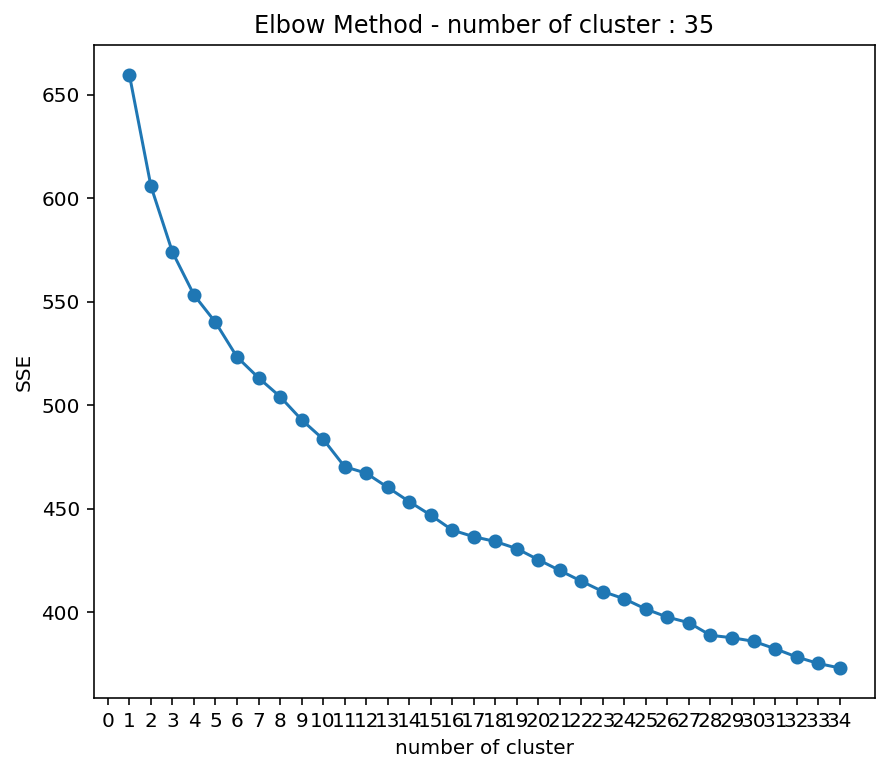

In [130]:
x = normalize(tfidf_matrix_okt)
# L2 정규화

def elbow(normalizedData, Clusters):
    sse = []
    for i in range(1,Clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
        kmeans.fit(normalizedData)
        sse.append(kmeans.inertia_)
    plt.figure(figsize=(7,6))
    plt.plot(range(1,Clusters), sse, marker='o')
    plt.xlabel('number of cluster')
    plt.xticks(np.arange(0,Clusters,1))
    plt.ylabel('SSE')
    plt.title('Elbow Method - number of cluster : '+str(Clusters))
    plt.show()
elbow(x, 35)

In [201]:
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize)
feature_vect = tfidf_vect.fit_transform(topic_df['TokenizedTitDesc'])

In [132]:

clusters_num = 15

km_cluster = KMeans(n_clusters=clusters_num, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [133]:
topic_df['cluster_label'] = cluster_label
topic_df.head()

for i in range(clusters_num):
  print('<<Clustering Label {0}>>'.format(i)+'\n')
  print(topic_df.loc[topic_df['cluster_label']==i])

<<Clustering Label 0>>

                                                                                                                       title + article  ... cluster_label
0          춘천 지역 방사 능 문제해결 시민 대책위 발족 강원 춘천 지역 방사 능 문제 해결 위 시민 대책 위원회 발족 춘천 방사 능 생활 감시 단 오후 시청 브리핑 룸 기자회견 지역 방사 능 문제 춘천 시민 연대 등 계해 시민 명  ...             0
1                            춘천 대학생 전입 장려 금 온라인 신청 폐지 춘천 지역 대학생 전입 장려 금 허위 신청 사례 춘천시 온라인 신청 춘천시 다른 지역 거주 전입 장려 금 허위 신청 거나 제출 서류 첨부 문제점  ...             0
3                                     한국 전쟁 첫 승전 춘천 대첩 오늘 한국 전쟁 당시 가장 먼저 국군 승전 고가 춘천 춘천 대첩 낙동강 전투 인천 상륙작전 한국 전쟁 대첩 정도 의미 우리 역사 기억 속 남아  ...             0
4                  강원도 춘천 부시장 자체 승진 인사 부동 불변 강원도 춘천시 검토 중인 부시장 자체 승진 인사 다시 한번 동의 의사 방침 강원도 집행 부 관계자 춘천시 자체 승진 통해 개월 임기 부시장 임명 것 도 군 협력  ...             0
5                    생활 개선 춘천시 농산물 꾸러미 사업 손 보태 한국 생활 개선 춘천시 연합 회 회장 변옥철 코로나 장기 화로 학교 식이 중단 것 관련 농산물 꾸러미 사업 인력 지원 지난 저녁 춘천 지역 먹거리 통합 센터  ...             0
..                                                  

In [134]:
clustersNum = topic_df['cluster_label'].groupby(topic_df['cluster_label']).count()
df= pd.DataFrame(clustersNum)

In [135]:
df.columns = ['count']
len(df['count'])

15

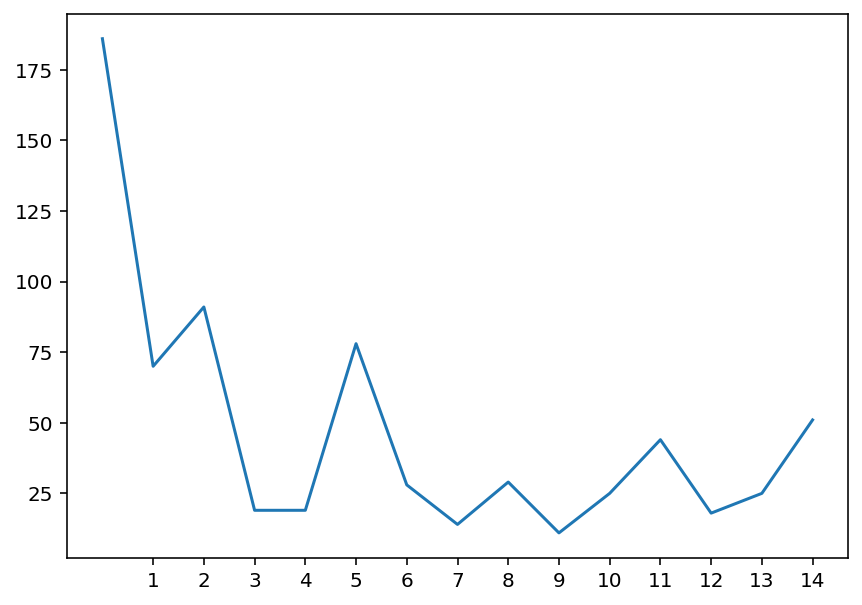

In [136]:
plt.figure(figsize=(7,5))
plt.plot(df.index, df['count'])
plt.xticks(np.arange(1, clusters_num))
plt.show()

In [137]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape : ', cluster_centers.shape)
print(cluster_centers)

cluster_centers shape :  (15, 2421)
[[0.00198744 0.         0.         ... 0.0029195  0.00254601 0.00260974]
 [0.         0.01832903 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.04010838]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [138]:
# 군집별 top n 핵심단어, 그 단어의 중심 위치 상대값, 대상 제목들을 반환함. 
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.  
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    #개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 제목 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화. 
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함. 
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['title']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['title'] = filenames
        
    return cluster_details

In [139]:
def print_cluster_details(cluster_details):    
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Title :',cluster_detail['title'][:7])
        print('==================================================')

In [140]:
feature_names = tfidf_vect.get_feature_names()

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=topic_df,\
                                  feature_names=feature_names, clusters_num=clusters_num, top_n_features=10 )
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['춘천', '구름', '날씨', '서울', '지역', '오후', '비', '맑음', '등', '도']
Title : ['춘천지역 방사능 문제해결 시민대책위 발족', '춘천 대학생 전입 장려금 온라인 신청 폐지', "한국전쟁 첫 승전고 '춘천대첩'", '강원도 "춘천 부시장 자체승진 인사, 부동의 불변"', '생활개선춘천시聯, 농산물 꾸러미사업에 손 보태', "'녹조라떼' 된 춘천 만천천", '춘천시, 2030년까지 사유림 1,135만㎡ 매입']
####### Cluster 1
Top features: ['대통령', '혁신', '서비스', '접목', '데이터', '빅데이터', '기업인', '플랫폼', '운영', '를']
Title : ['문재인 정부 D+1131', '데이터·AI 접목한 혁신 서비스 설명듣는 문 대통령', '문 대통령, 데이터·AI 접목 혁신 서비스 개발자와 차담회', '마스크 벗는 문 대통령', '물 마시는 문 대통령', '생각에 잠긴 문 대통령', '발언하는 문 대통령']
####### Cluster 2
Top features: ['도', '기온', '낮', '서울', '강릉', '제주', '대전', '인천', '최고', '대구']
Title : ['낮 기온 30도 안 넘는다…남부엔 많은 비', '전국 흐리고 남부지방에 비…낮 최고 29도', '내일 서울·경기 출근길 비…오후 충청·남부내륙 소나기', '[내일날씨] 전국 흐리고 곳곳에 비…낮 최고기온 30도', '[날씨] 제주·남부 새벽까지 비…내일 다시 맑고 낮더위', '[오늘 날씨] 흐리고 곳곳에 비…제주도 최대 200㎜ 폭우', "[오늘날씨] 남부지방·제주도 '비'…미세먼지 '보통'"]
####### Cluster 3
Top features: ['속초', '이용', '캐슬', '롯데', '수', '춘천지방검찰청', '지청', '하나로마트', '회관', '생활']
Title : ["'속초 롯데캐슬 인더스카이' 서울 홍보관 운영", 

In [141]:
# 토큰화 된 문장 리스트를 단어별로 split한 후 2차원 리스트로 저장
WordVoca_list = []
for item in TitDesc_okt:
    WordVoca_list.append(item.split(' '))

# split된 2차원 리스트 중에서 한 글자짜리 단어들을 모두 제외시키고 WordVoca 리스트 생성
# Word2Vec 모델 학습 데이터로 활용됨
WordVoca = []
for i in range(len(WordVoca_list)):
    element = []
    for j in range(len(WordVoca_list[i])):
        if len(WordVoca_list[i][j]) > 1:
            element.append(WordVoca_list[i][j])
    WordVoca.append(element)

In [142]:
def WordSimilarity(word, count):
    model = Word2Vec(sentences=WordVoca, size=100, window=5, min_count=5, workers=4, sg=1)
    model_result = model.most_similar(positive=[word], topn=count)

    Similarity_df = pd.DataFrame(model_result, columns=[word,'Similarity'])
    print('{0}과 유사한 단어 Top {1} :'.format(word, count))
    print(Similarity_df)

In [143]:
WordSimilarity('더존', 10)

더존과 유사한 단어 Top 10 :
     더존  Similarity
0    비즈    0.999281
1   데이터    0.997801
2    방문    0.997706
3   개발자    0.997413
4   문재인    0.997075
5   대통령    0.996784
6  과학기술    0.995103
7    소재    0.993652
8    격려    0.993630
9    관련    0.992437


## Topic Modeling

In [159]:
from sklearn.decomposition import LatentDirichletAllocation
cnt_vect = CountVectorizer(tokenizer=LemNormalize,)

In [207]:
dtm = tfidf_vect.fit_transform(topic_df['TokenizedTitDesc'])

In [216]:
n_topics = 10

lda = LatentDirichletAllocation(n_components=n_topics)
lda.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [206]:
names = tfidf_vect.get_feature_names()
topics = dict()

for idx, topic in enumerate(lda.components_):
    vocab = []
    for i in topic.argsort()[:-(30-1):-1]:
        vocab.append((names[i], topic[i].round(2)))
    print('주제 : {0}'.format(idx+1))
    print([(names[i], topic[i].round(2)) for i in topic.argsort()[:-(30-1):-1]])

주제 : 1
[('농협', 1.99), ('강원', 1.79), ('농민', 1.72), ('종전', 1.6), ('선언', 1.6), ('활용', 1.49), ('지역', 1.36), ('총회', 1.13), ('중단', 1.1), ('정기', 1.09), ('북한', 1.05), ('의원', 1.04), ('상', 1.03), ('레저', 1.02), ('카드', 1.01), ('이', 1.01), ('한기호', 1.01), ('별세', 1.0), ('창업', 0.99), ('기념', 0.97), ('접근성', 0.96), ('집', 0.96), ('성명', 0.95), ('수상', 0.91), ('춘천', 0.9), ('고려', 0.9), ('연락', 0.88), ('사무소', 0.88)]
주제 : 2
[('대통령', 57.58), ('뉴딜', 36.6), ('문재인', 35.7), ('더존', 34.26), ('비즈', 32.64), ('온', 32.58), ('데이터', 31.94), ('방문', 31.8), ('디지털', 27.72), ('문', 25.3), ('한국판', 23.95), ('강원도', 22.95), ('현장', 21.81), ('위치', 20.06), ('기업', 18.91), ('캠퍼스', 18.72), ('강촌', 18.62), ('경제', 17.66), ('빅데이터', 17.36), ('플랫폼', 16.75), ('서비스', 16.62), ('혁신', 16.58), ('기업인', 16.49), ('운영', 15.79), ('설명', 15.17), ('접목', 14.47), ('춘천', 14.18), ('첫', 14.02)]
주제 : 3
[('우수', 2.69), ('제', 2.4), ('대상', 2.37), ('의정', 2.37), ('변호사', 2.3), ('도의', 1.84), ('기', 1.79), ('명', 1.7), ('호', 1.49), ('평창', 1.4), ('수상자', 1.38), ('삼척', 1.34), ('강

In [232]:
feature_vect_cnt = cnt_vect.fit_transform(topic_df['TokenizedTitDesc'])
lda2 = LatentDirichletAllocation(n_components=n_topics, topic_word_prior=0.01, doc_topic_prior=0.001)
lda2.fit(dtm)

names = cnt_vect.get_feature_names()
topics_word = dict()
n_words = 20

for idx, topic in enumerate(lda2.components_):
    vocab = []
    for i in topic.argsort()[:-(30-1):-1]:
        vocab.append((names[i], topic[i].round(2)))
    topics_word[idx+1] = [(names[i], topic[i].round(2)) for i in topic.argsort()[:-(n_words-1):-1]]
max_dict = dict()

for idx, vec in enumerate(lda2.transform(dtm)):
    t = vec.argmax()
    if (t not in max_dict):
        max_dict[t] = (vec[t], idx)
    else:
        if (max_dict[t][0] < vec[t]):
            max_dict[t] = (vec[t], idx)
sorted_news = sorted(max_dict.items(), key = lambda x: x[0], reverse=False)

for key, value in sorted_news:
    print('주제 {0}: {1}]'.format(key+1, topics_word[key+1]))
    print('[주제 {}의 대표 기사 : {}]\n{}\n\n'.format(key+1, value[0], topic_df['title'][value[1]]))

주제 1: [('명', 2.38), ('전', 2.28), ('검사', 2.28), ('여성', 2.28), ('유적', 2.27), ('변호사', 2.25), ('방사', 2.25), ('공원', 2.22), ('레고랜드', 2.07), ('캠프', 1.81), ('페이지', 1.81), ('능', 1.77), ('기', 1.73), ('후보', 1.73), ('의원', 1.7), ('사업', 1.66), ('작업', 1.63), ('대법관', 1.6)]]
[주제 1의 대표 기사 : 0.9983747475933837]
대법관 후보 30명 발표.. '文 검찰개혁' 설계한 김인회 교수 포함


주제 2: [('대통령', 11.6), ('혁신', 10.81), ('서비스', 10.62), ('접목', 10.61), ('회', 10.39), ('직원', 9.41), ('빅데이터', 8.97), ('기업인', 8.83), ('를', 8.82), ('운영', 8.76), ('플랫폼', 8.67), ('개발', 8.49), ('데이터', 8.41), ('위치', 7.41), ('문재인', 7.33), ('강원도', 6.87), ('비즈', 6.38), ('온', 6.36)]]
[주제 2의 대표 기사 : 0.9984335994560911]
[더벨][두산그룹 구조조정]두산건설 물적분할에 등장한 '두산큐벡스' 역할은


주제 3: [('부', 4.65), ('씨', 3.98), ('재판', 3.64), ('징역', 3.17), ('수감자', 2.91), ('폭행', 2.78), ('혐의', 2.65), ('고법', 2.54), ('형사', 2.48), ('기분', 2.48), ('자동차세', 2.48), ('선고', 2.38), ('기소', 2.35), ('박재우', 2.31), ('치사', 2.22), ('제', 2.18), ('기각', 2.18), ('항소', 2.18)]]
[주제 3의 대표 기사 : 0.9983558489530304]
전직 광주MBC 사장이 왜 검찰 체포

In [184]:
names = cnt_vect.get_feature_names()
topics_word = dict()
n_words = 15

for idx, topic in enumerate(lda.components_):
    vocab = []
    for i in topic.argsort()[:-(30-1):-1]:
        vocab.append((names[i], topic[i].round(2)))
    topics_word[idx+1] = [(names[i], topic[i].round(2)) for i in topic.argsort()[:-(n_words-1):-1]]
max_dict = dict()

for idx, vec in enumerate(lda.transform(dtm)):
    t = vec.argmax()
    if (t not in max_dict):
        max_dict[t] = (vec[t], idx)
    else:
        if (max_dict[t][0] < vec[t]):
            max_dict[t] = (vec[t], idx)
sorted_news = sorted(max_dict.items(), key = lambda x: x[0], reverse=False)

for key, value in sorted_news:
    print('주제 {0}: {1}]'.format(key+1, topics_word[key+1]))
    print('[주제 {}의 대표 기사 : {}]\n{}\n\n'.format(key+1, value[0], topic_df['title'][value[1]]]))

주제 1: [('농협', 1.99), ('강원', 1.79), ('농민', 1.72), ('종전', 1.6), ('선언', 1.6), ('활용', 1.49), ('지역', 1.36), ('총회', 1.13), ('중단', 1.1), ('정기', 1.09), ('북한', 1.05), ('의원', 1.04), ('상', 1.03)]]


IndexError: ignored

In [221]:
topic_df['TitDesc']

0                                                                               춘천지역 방사능 문제해결 시민대책위 발족
1                                                                              춘천 대학생 전입 장려금 온라인 신청 폐지
2                                                                춘천 기업 달려가 "데이터댐" 외친 文···'한국판 뉴딜' 첫 행보
3                                                                                    한국전쟁 첫 승전고 '춘천대첩'
4                                                                         강원도 "춘천 부시장 자체승진 인사, 부동의 불변"
                                                    ...                                               
703                                                               文대통령 "디지털 뉴딜은 데이터 활용한 ‘데이터 댐’ 만드는 것"
704                                                               오늘 6월 모의수능평가 실시 '12월 3일 치뤄질 수능 준비 격'
705                                                                서울르엘캐슬 갤러리 홍보관 운영나선 '속초 롯데캐슬 인더스카이'
706    기상청 발표 오늘의 날씨, 내일 날씨, 일출 시간-전국 흐린 가운데 전라도, 경상남북도, 제주도 비, 오늘 밤 대부분 